In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
#from pyramid.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from fbprophet import Prophet

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [3]:
df=pd.read_excel("REGNANDATA.xlsx",parse_dates=[0])
df.head()

,year,Credit Card POS Count,Debit Card POS Count,RTGS,NEFT
0,2015-01-01,17947247.0,11151245.0,889032.0,16342282.0
1,2015-02-01,15602279.0,10288412.0,865068.0,19244474.0
2,2015-03-01,NaN,11582587.0,1072737.0,26906303.0
3,2015-04-01,18188579.0,12044987.0,895710.0,17862349.0
4,2015-05-01,19313259.0,13368953.0,NaN,21496984.0


In [3]:
df.isnull().sum()

year                     0
Credit Card POS Count    6
Debit Card POS Count     4
RTGS                     5
NEFT                     8
dtype: int64

In [4]:
df1=df.fillna(df.mean())
df1.head()

,year,Credit Card POS Count,Debit Card POS Count,RTGS,NEFT
0,2015-01-01,1.794725e+07,11151245.0,8.890320e+05,16342282.0
1,2015-02-01,1.560228e+07,10288412.0,8.650680e+05,19244474.0
2,2015-03-01,3.273981e+07,11582587.0,1.072737e+06,26906303.0
3,2015-04-01,1.818858e+07,12044987.0,8.957100e+05,17862349.0
4,2015-05-01,1.931326e+07,13368953.0,1.149440e+06,21496984.0


In [5]:
df2=df1.assign(Total_transactions=df1['Credit Card POS Count']+df1['Debit Card POS Count']+df1['RTGS']+df1['NEFT'])
df2.head()

,year,Credit Card POS Count,Debit Card POS Count,RTGS,NEFT,Total_transactions
0,2015-01-01,1.794725e+07,11151245.0,8.890320e+05,16342282.0,4.632981e+07
1,2015-02-01,1.560228e+07,10288412.0,8.650680e+05,19244474.0,4.600023e+07
2,2015-03-01,3.273981e+07,11582587.0,1.072737e+06,26906303.0,7.230144e+07
3,2015-04-01,1.818858e+07,12044987.0,8.957100e+05,17862349.0,4.899162e+07
4,2015-05-01,1.931326e+07,13368953.0,1.149440e+06,21496984.0,5.532864e+07


In [17]:
df2.corr() # can be seen that there is high correlation in debit card pos count and credit card pos count
# and also high correlation between total_transactions with debit card and credit card

,Credit Card POS Count,Debit Card POS Count,RTGS,NEFT,Total_transactions
Credit Card POS Count,1.000000,0.867077,0.608107,0.155206,0.943083
Debit Card POS Count,0.867077,1.000000,0.601143,0.116474,0.961444
RTGS,0.608107,0.601143,1.000000,0.349437,0.666535
NEFT,0.155206,0.116474,0.349437,1.000000,0.298957
Total_transactions,0.943083,0.961444,0.666535,0.298957,1.000000


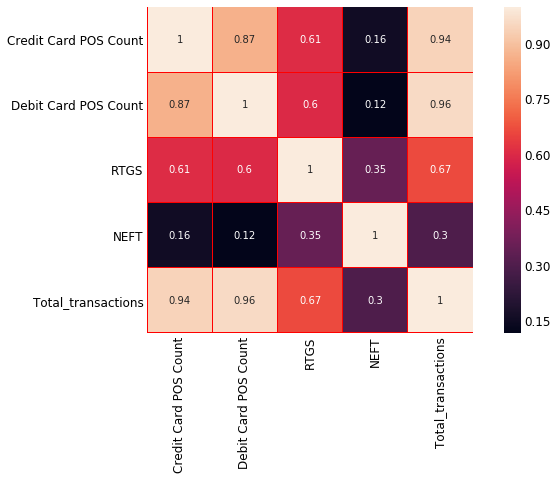

In [135]:
import seaborn as sns
sns.heatmap(df2.corr(),linewidth=0.2,vmax=1.0,square=True,linecolor='red',annot=True)

In [6]:
df3=df2.drop(['Credit Card POS Count','Debit Card POS Count','RTGS','NEFT'],axis=1)
df3.head()

,year,Total_transactions
0,2015-01-01,4.632981e+07
1,2015-02-01,4.600023e+07
2,2015-03-01,7.230144e+07
3,2015-04-01,4.899162e+07
4,2015-05-01,5.532864e+07


In [7]:
df3.isnull().sum()

year                  0
Total_transactions    0
dtype: int64

In [8]:
df3.describe()

,Total_transactions
count,6.000000e+01
mean,8.900457e+07
std,2.341117e+07
min,4.600023e+07
25%,6.802919e+07
50%,9.422284e+07
75%,1.071568e+08
max,1.356472e+08


In [9]:
print('Time period start: {}\nTime period end: {}'.format(df3.year.min(),df3.year.max()))

Time period start: 2015-01-01 00:00:00
Time period end: 2019-12-01 00:00:00


In [10]:
df3.columns

Index(['year', 'Total_transactions'], dtype='object')

In [11]:
df3.shape

(60, 2)

In [12]:
# data preprocessing 

In [13]:
df4=df3.set_index('year')

In [14]:
df4.index

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'], dtype='datetime64[ns]', name='year', freq=None)

In [15]:
df4.head()

,Total_transactions
year,
2015-01-01,4.632981e+07
2015-02-01,4.600023e+07
2015-03-01,7.230144e+07
2015-04-01,4.899162e+07
2015-05-01,5.532864e+07


In [18]:
df4.isnull().sum()

Total_transactions    0
dtype: int64

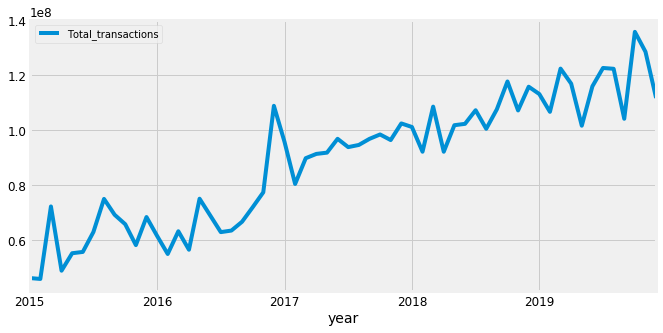

In [19]:
df4.plot(figsize=(10,5))
plt.show()
# cleary seen that data is not normally distributed

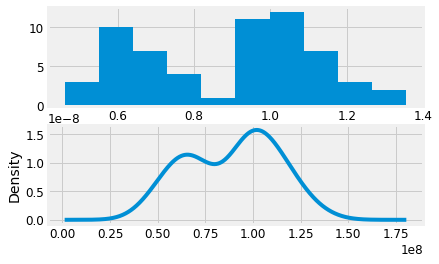

In [20]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
df4.Total_transactions.hist()
pyplot.subplot(212)
df4.Total_transactions.plot(kind='kde')
pyplot.show()
# can see that distribution is not normally distributed
# it is right distributed
# transformations might be useful while modelling

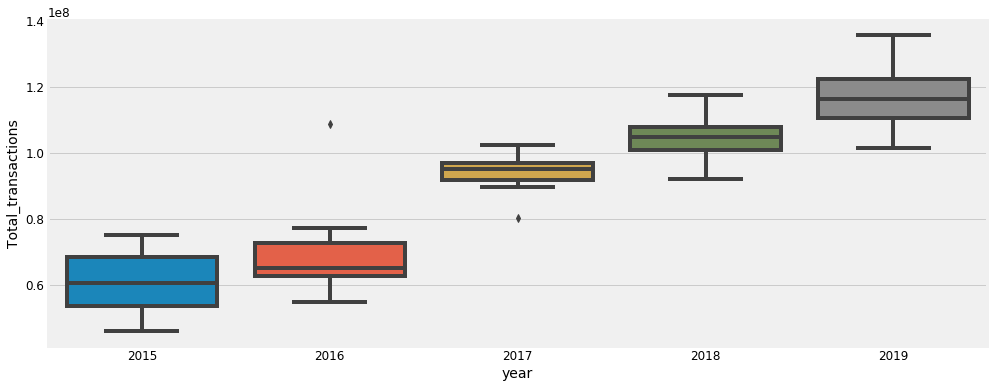

In [21]:
# box whisker plot
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(df4.Total_transactions.index.year, df4.Total_transactions, ax=ax)
# median values across year confirm upwward trend
# increase in middle 50% of data over time

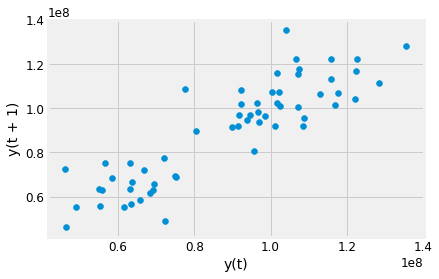

In [22]:
from pandas.plotting import lag_plot
lag_plot(df4)
# showing positive correlation betwenn 1 lag time


### Decomposing using statsmodel:

We can use statsmodels to perform a deccomposition
IT deconstructs a time series into several components, each representing one of the underlying categories of patterns.
With statsmodels we will be able to see the trend, seasonal, and residual components of our data.

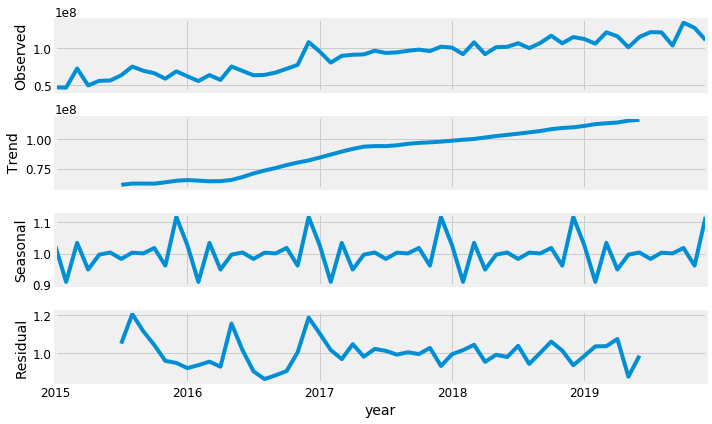

In [22]:
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
decomposition = sm.tsa.seasonal_decompose(df4, model='multiplicative')
a = decomposition.plot()
plt.show()
# original data plot have increasing pattern
# can be clearly seen that trend was constant till mid 2016 and then started increasing and then slightly decreasing and then increasing only
# in seasonal plot, we can see transactions increase in december each year 
# and residuals are have more fluctuations till 2017 , after that its not increasing much thus they are less only

### Stationarity
stationary means that statistical properties such as mean, variance remain constant over time.

Most of the Time Series models work on the assumption that the Time series is stationary. Major reason for this is that there are many ways in which a series can be non-stationary, but only one way for stationarity.

Intuitively, we can say that if a Time Series has a particular behaviour over time, there is a very high probability that it will follow the same in the future.

Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

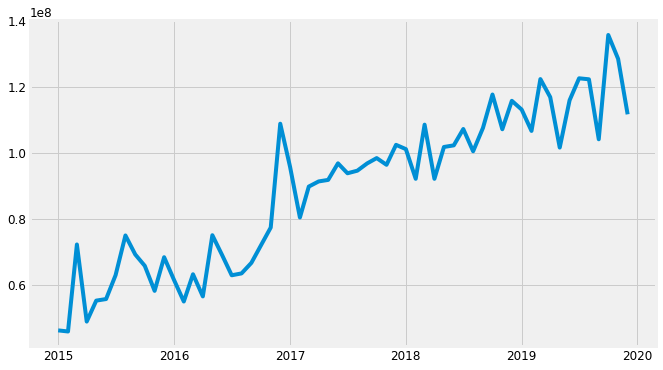

In [23]:
plt.plot(df4)

### We can check stationarity using the following:

ACF and PACF plots: If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.

Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. Moving average/variance is for any instant ‘t’, the average/variance of the last year, i.e. last 12 months.

Augmented Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

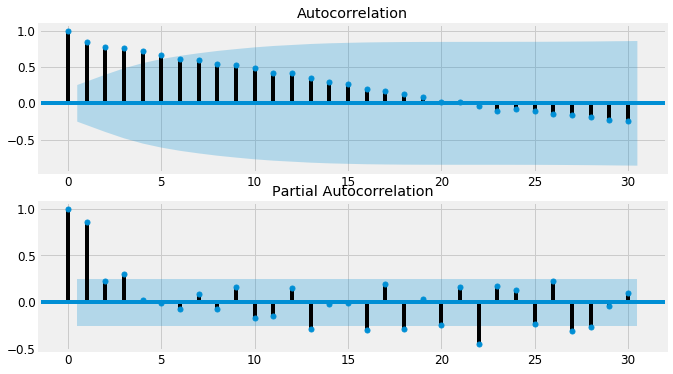

In [24]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.subplot(211)
plot_acf(df4.Total_transactions, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(df4.Total_transactions, ax=pyplot.gca(), lags = 30)
pyplot.show()

# As correlation measures the extent of a linear relationship between two variables,
# autocorrelation measures the linear relationship between lagged values of a time series.

# When data have a trend, the autocorrelations for small lags tend to be large and positive because observations nearby in time are also nearby in size.
# So the ACF of trended time series tend to have positive values that slowly decrease as the lags increase.

# When data are seasonal, the autocorrelations will be larger for the seasonal lags (at multiples of the seasonal frequency) than for other lags.

# When data are both trended and seasonal, you see a combination of these effects

### ACF and PACF plots
Let's review the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots:

If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.

This data is non-stationary as a high number of previous observations are correlated with future values.

The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.


In [ ]:
### Plotting rolling statistics

In [25]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['Total_transactions'])
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

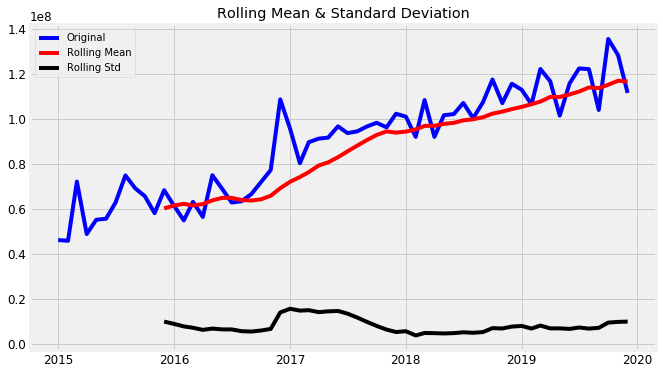

Results of Dickey-Fuller Test:
Test Statistic                 -0.674172
p-value                         0.853327
Lags Used                       2.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64


In [26]:
test_stationarity(df4)

### We observe that the rolling mean and Standard deviation are not constant with respect to time (increasing trend)
The time series is hence not stationary

Augmented Dickey-Fuller Test

The intuition behind the test is that if the series is integrated then the lagged level of the series df4(t-1) will provide no relevant information in predicting the change in df4(t).

Null hypothesis: The time series is not stationary.
Rejecting the null hypothesis (i.e. a very low p-value) will indicate staionarity

and as p value is greater than critical values so reject the H0

### Making Time Series Stationary
There are 2 major reasons behind non-stationaruty of a TS:

Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.

Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

Transformations
We can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity:

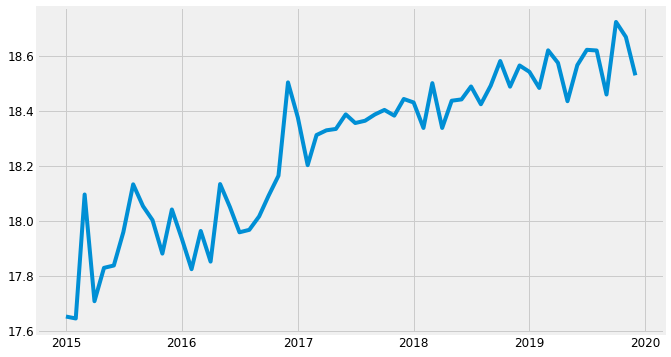

In [27]:
# log scale transformations
ts_log=np.log(df4)
plt.plot(ts_log)

### Moving Average
We take average of ‘k’ consecutive values depending on the frequency of time series.

Here we can take the average over the last 12 values.

A drawback in this particular approach is that the time-period has to be strictly defined

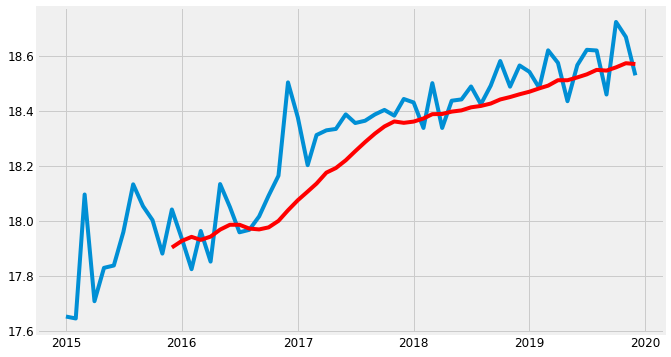

In [28]:
moving_avg=ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg,color='red')

In [29]:
ts_log_ma_diff=ts_log-moving_avg
ts_log_ma_diff.head(14)

,Total_transactions
year,
2015-01-01,NaN
2015-02-01,NaN
2015-03-01,NaN
2015-04-01,NaN
2015-05-01,NaN
2015-06-01,NaN
2015-07-01,NaN
2015-08-01,NaN
2015-09-01,NaN


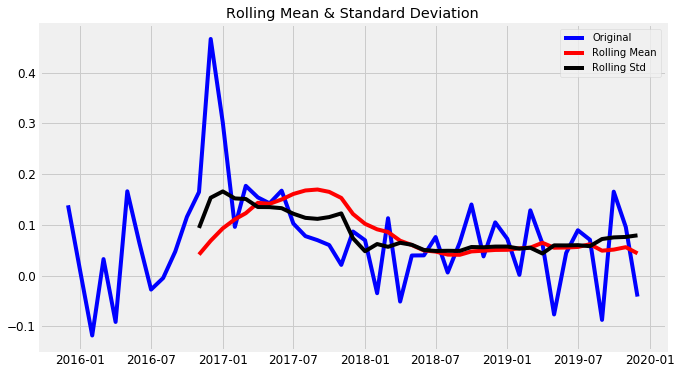

Results of Dickey-Fuller Test:
Test Statistic                 -4.722569
p-value                         0.000076
Lags Used                       0.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


In [30]:
ts_log_ma_diff.dropna(inplace=True)
test_stationarity(ts_log_ma_diff)

In [31]:
# as test_statistic < 1% critical value. ie data is stationary 99%

other technique to remove seasonality and trend:
### Differencing:

In this technique, we take the difference of the observation at a particular instant with that at the previous instant.

First order differencing in Pandas

In [38]:
ts_log_diff=ts_log-ts_log.shift()
ts_log_diff.head()

,Total_transactions
year,
2015-01-01,NaN
2015-02-01,-0.007139
2015-03-01,0.452198
2015-04-01,-0.389195
2015-05-01,0.121641


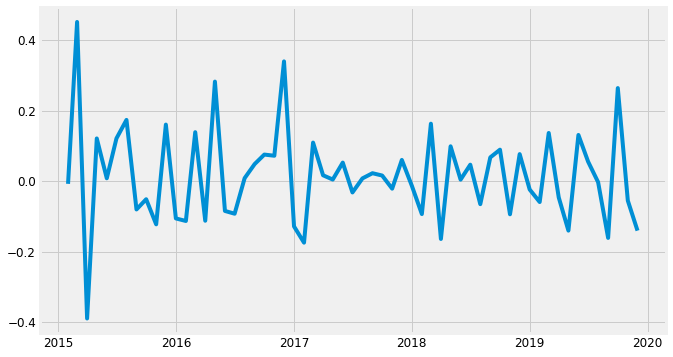

In [33]:
plt.plot(ts_log_diff)

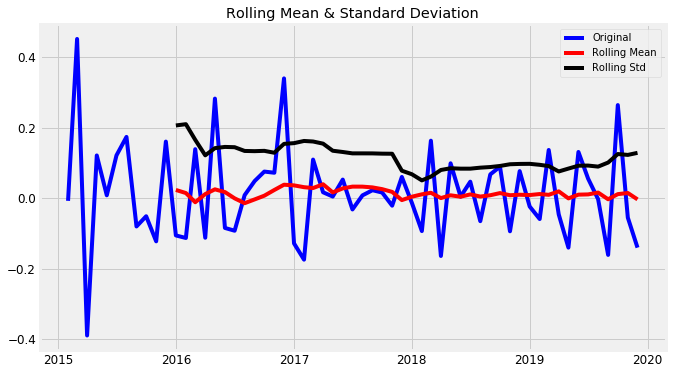

Results of Dickey-Fuller Test:
Test Statistic                -9.515190e+00
p-value                        3.171034e-16
Lags Used                      1.000000e+00
Number of Observations Used    5.700000e+01
Critical Value (1%)           -3.550670e+00
Critical Value (5%)           -2.913766e+00
Critical Value (10%)          -2.594624e+00
dtype: float64


In [35]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [36]:
# here also test_statistic < 1% critical value
# thus data is 99% stationary

# Decomposition
In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned.


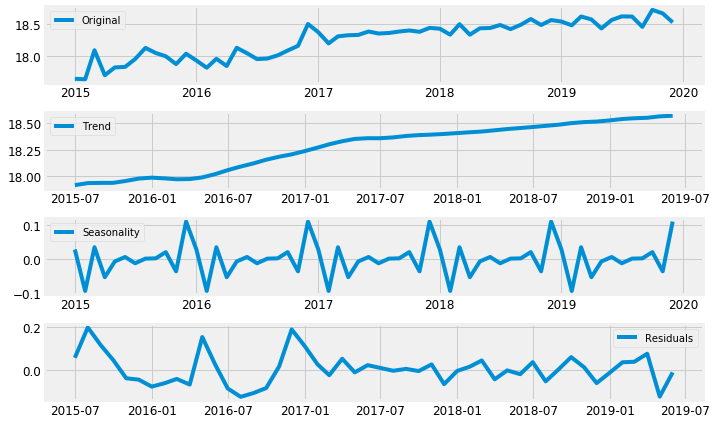

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

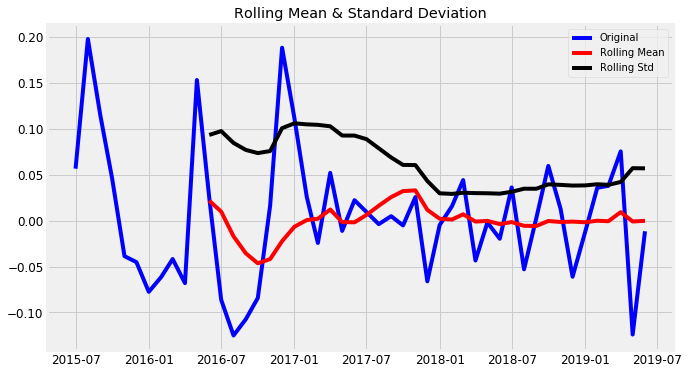

Results of Dickey-Fuller Test:
Test Statistic                 -5.322793
p-value                         0.000005
Lags Used                       2.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64


In [35]:
ts_log_decom=residual
ts_log_decom.dropna(inplace=True)
test_stationarity(ts_log_decom)

## Time series forecasting 

### Autoregression
The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps.

Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

In [39]:
from statsmodels.tsa.ar_model import AR
from random import random

In [42]:
ts_log_diff.dropna(inplace=True)
ts_log_diff

,Total_transactions
year,
2015-02-01,-0.007139
2015-03-01,0.452198
2015-04-01,-0.389195
2015-05-01,0.121641
2015-06-01,0.008532
2015-07-01,0.121824
2015-08-01,0.174286
2015-09-01,-0.079804
2015-10-01,-0.050804


In [43]:
# fit model
model=AR(ts_log_diff)
model_fit=model.fit()

C:\Users\navod\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


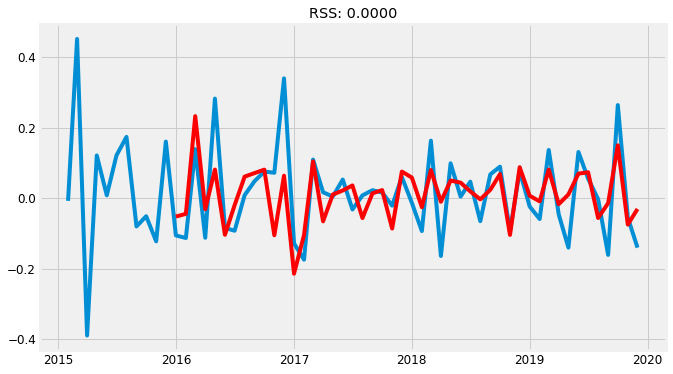

In [44]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()

### Reversing the transformations

PREDICTED VALUES:

In [137]:
predictions_AR_diff = pd.Series(model_fit.fittedvalues, copy=True)
predictions_AR_diff.head()

year
2015-02-01    0.014698
2015-03-01    0.024225
2015-04-01   -0.228679
2015-05-01    0.087687
2015-06-01    0.011126
dtype: float64

### Cumulative sum to reverse differencing

In [138]:
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()
print (predictions_AR_diff_cumsum.head())

year
2015-02-01    0.014698
2015-03-01    0.038923
2015-04-01   -0.189756
2015-05-01   -0.102069
2015-06-01   -0.090943
dtype: float64


### Adding 1st month value which was previously removed while differencing:



In [139]:
predictions_AR_log = pd.Series(ts_log.Total_transactions.iloc[0], index=ts_log.index)
predictions_AR_log = predictions_AR_log.add(predictions_AR_diff_cumsum,fill_value=0)
predictions_AR_log.head()

year
2015-01-01    17.651296
2015-02-01    17.665994
2015-03-01    17.690219
2015-04-01    17.461540
2015-05-01    17.549227
dtype: float64

### Taking exponent to reverese Log transform

In [141]:
predictions_AR = np.exp(predictions_AR_log)


Text(0.5, 1.0, 'RMSE: 42238280.9020')

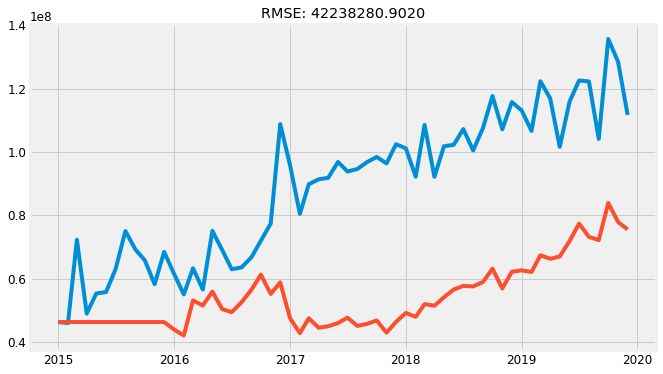

In [142]:
plt.plot(df4.Total_transactions)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_AR-df4.Total_transactions)**2)/len(df4.Total_transactions)))

### Forecast quality scoring metrics
R squared

Mean Absolute Error

Median Absolute Error

Mean Squared Error

Mean Squared Logarithmic Error

Mean Absolute Percentage Error

In [54]:

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

### R squared, coefficient of determination (it can be interpreted as a percentage of variance explained by the model), (-inf, 1]

sklearn.metrics.r2_score

In [55]:
r2_score(df4.Total_transactions, predictions_ARIMA)

-1.806473110474124

### Mean Absolute Error, it is an interpretable metric because it has the same unit of measurement as the initial series, [0, +inf)

sklearn.metrics.mean_absolute_error

In [56]:
mean_absolute_error(df4.Total_transactions, predictions_ARIMA)


34671616.65035321

### Median Absolute Error, again an interpretable metric, particularly interesting because it is robust to outliers, [0, +inf)

sklearn.metrics.median_absolute_error

In [57]:
median_absolute_error(df4.Total_transactions, predictions_ARIMA)


43457407.15055741


### Mean Squared Error, most commonly used, gives higher penalty to big mistakes and vise versa, [0, +inf)

sklearn.metrics.mean_squared_error

In [58]:
mean_squared_error(df4.Total_transactions, predictions_ARIMA)


1512543249410656.8

### Mean Absolute Percentage Error, same as MAE but percentage, — very convenient when you want to explain the quality of the model to your management, [0, +inf),

not implemented in sklearn

In [59]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [60]:
mean_absolute_percentage_error(df4.Total_transactions, predictions_ARIMA)


36.14990918515285

In [61]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [62]:
evaluate_forecast(df4.Total_transactions, predictions_ARIMA)


,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,-1.806473,3.467162e+07,4.345741e+07,1.512543e+15,0.269468,36.149909,3.889143e+07


###  RMSE has the benefit of penalizing large errors more so can be more appropriate in some cases, for example, if being off by 10 is more than twice as bad as being off by 5. But if being off by 10 is just twice as bad as being off by 5, then MAE is more appropriate.

From an interpretation standpoint, MAE is clearly the winner. RMSE does not describe average error alone and has other implications that are more difficult to tease out and understand.

On the other hand, one distinct advantage of RMSE over MAE is that RMSE avoids the use of taking the absolute value, which is undesirable in many mathematical calculations

## Moving Average (MA)¶

Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

In [124]:
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model = ARMA(ts_log_diff, order=(0, 1))
model_fit = model.fit(disp=False)

C:\Users\navod\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [125]:
model_fit.summary() 
# both AIC and BIC values are very less and p values also satisfies

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:     Total_transactions   No. Observations:                   59
Model:                     ARMA(0, 1)   Log Likelihood                  45.464
Method:                       css-mle   S.D. of innovations              0.111
Date:                Mon, 13 Apr 2020   AIC                            -84.928
Time:                        13:56:46   BIC                            -78.695
Sample:                    02-01-2015   HQIC                           -82.495
                         - 12-01-2019                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0148      0.004      3.861      0.000       0.007       0.022
ma.L1.Total_transactions    -0.7500      0.113     -6.620      0.000      -0.972      -0.528
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.3334           +0.0000j            1.3334            0.0000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 0.0000')

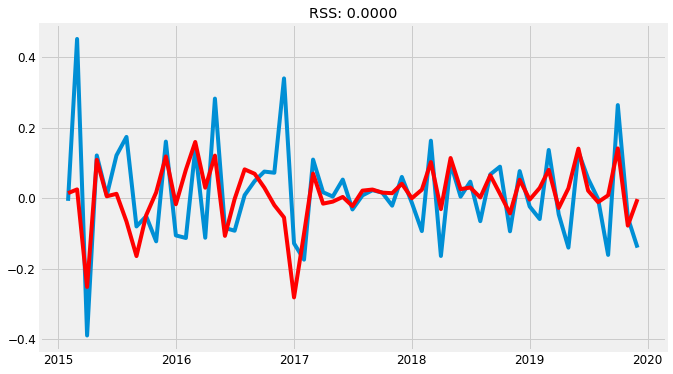

In [126]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

In [127]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [128]:
mean_absolute_error(df4[start_index:end_index],predictions)

116749442.63950129

## Autoregressive Moving Average (ARMA)

Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

In [129]:
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model = ARMA(ts_log_diff, order=(2, 1))
model_fit = model.fit(disp=False)

C:\Users\navod\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [130]:
model_fit.summary()
# AIC and BIC values are greater than MOVING AVERAGES MODEL 
# and p values does not satisfy for any of the time lag except no time lag 
# when p paramter =0 then test statistic value satisfies and this model becomes equal to MOVING AVERAGES MODEL

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:     Total_transactions   No. Observations:                   59
Model:                     ARMA(2, 1)   Log Likelihood                  45.571
Method:                       css-mle   S.D. of innovations              0.111
Date:                Mon, 13 Apr 2020   AIC                            -81.143
Time:                        13:57:36   BIC                            -70.755
Sample:                    02-01-2015   HQIC                           -77.088
                         - 12-01-2019                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0147      0.004      4.027      0.000       0.008       0.022
ar.L1.Total_transactions     0.0526      0.377      0.139      0.890      -0.687       0.792
ar.L2.Total_transactions    -0.0381      0.294     -0.129      0.897      -0.615       0.539
ma.L1.Total_transactions    -0.7661      0.366     -2.093      0.041      -1.483      -0.049
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6905           -5.0750j            5.1217           -0.2285
AR.2            0.6905           +5.0750j            5.1217            0.2285
MA.1            1.3053           +0.0000j            1.3053            0.0000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 0.0000')

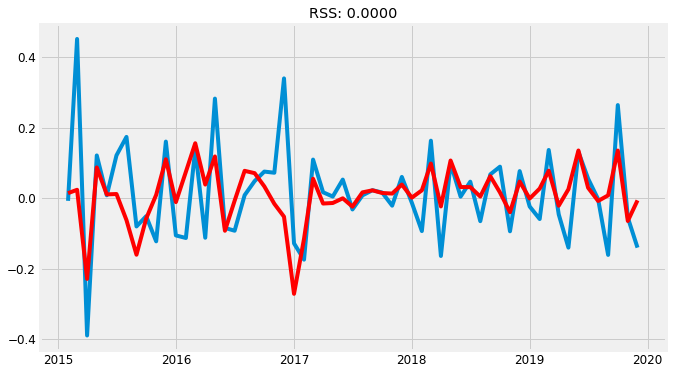

In [131]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

In [132]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [133]:
mean_absolute_error(df4[start_index:end_index],predictions)

116749442.6384996

## Autoregressive Integrated Moving Average (ARIMA)

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

Number of Differences (d): d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.

Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.


### Observations from EDA on the time series:

Non stationarity implies at least one level of differencing (d) is required in ARIMA

The next step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively, using PACF, ACF plots
Tuning ARIMA parameters

A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

In [85]:
ts = df4.Total_transactions - df4.Total_transactions.shift()
ts.dropna(inplace=True) # taking the difference between actual series and series obtained by shifting one value

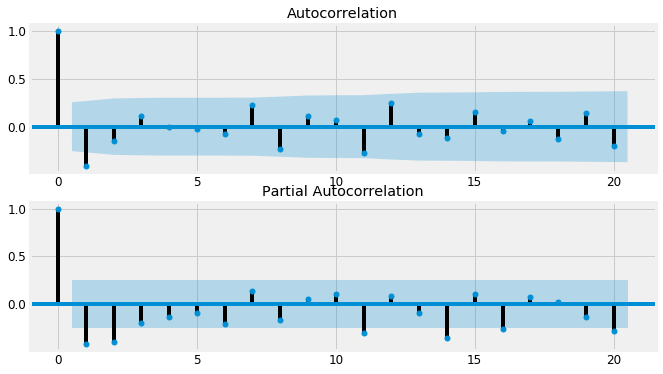

In [88]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts, ax=pyplot.gca(),lags=20)
pyplot.subplot(212)
plot_pacf(ts, ax=pyplot.gca(),lags=20)
pyplot.show()
# as acf plot have 2nd lag negative ie data is stationary now

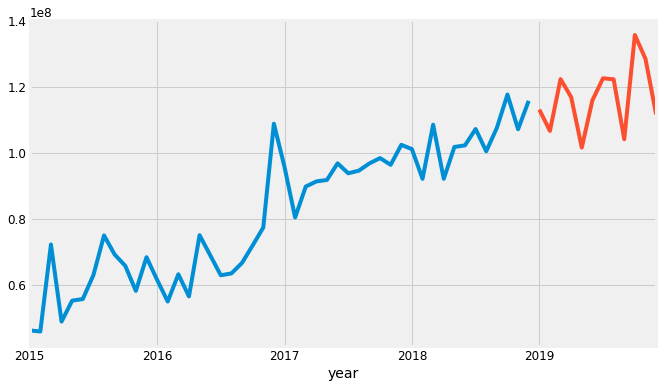

In [89]:
#divide into train and validation set
train = df4[:int(0.80*(len(df4)))]
valid = df4[int(0.80*(len(df4))):]

#plotting the data
train['Total_transactions'].plot()
valid['Total_transactions'].plot() # splitting the data into 80:20

In [90]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit(disp=1)

C:\Users\navod\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\navod\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\navod\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [91]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARIMA Model Results                               
================================================================================
Dep. Variable:     D.Total_transactions   No. Observations:                   47
Model:                   ARIMA(1, 1, 1)   Log Likelihood                -816.482
Method:                         css-mle   S.D. of innovations        8249544.006
Date:                  Mon, 13 Apr 2020   AIC                           1640.965
Time:                          13:30:48   BIC                           1648.366
Sample:                      02-01-2015   HQIC                          1643.750
                           - 12-01-2018                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       1.477e+06        nan        nan        nan         nan         nan
ar.L1.D.Total_transactions     0.2917      0.156      1.866      0.069      -0.015       0.598
ma.L1.D.Total_transactions    -0.9823        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.4283           +0.0000j            3.4283            0.0000
MA.1            1.0180           +0.0000j            1.0180            0.0000
-----------------------------------------------------------------------------
"""

In [92]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [93]:
mse = mean_squared_error(df4[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 115612627.27025919, MSE:1.3366279584331878e+16


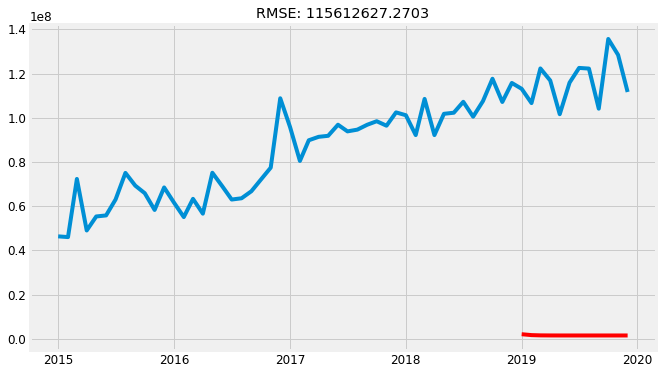

In [94]:
plt.plot(df4.Total_transactions)
plt.plot(predictions, color='red')
plt.title('RMSE: %.4f'% rmse)
plt.show()

In [95]:
# predicted values:
predictions_ARIMA_diff = pd.Series(predictions, copy=True)
print (predictions_ARIMA_diff.head())

2019-01-01    2.045875e+06
2019-02-01    1.642830e+06
2019-03-01    1.525267e+06
2019-04-01    1.490975e+06
2019-05-01    1.480973e+06
Freq: MS, dtype: float64


In [96]:
# Cumulative Sum to reverse differencing:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

2019-01-01    2.045875e+06
2019-02-01    3.688705e+06
2019-03-01    5.213972e+06
2019-04-01    6.704947e+06
2019-05-01    8.185919e+06
Freq: MS, dtype: float64


In [97]:
# Adding 1st month value which was previously removed while differencing:

predictions_ARIMA_log = pd.Series(valid.Total_transactions.iloc[0], index=valid.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

year
2019-01-01    1.151330e+08
2019-02-01    1.167758e+08
2019-03-01    1.183011e+08
2019-04-01    1.197921e+08
2019-05-01    1.212730e+08
dtype: float64

Text(0.5, 1.0, 'RMSE: 56270710.9342')

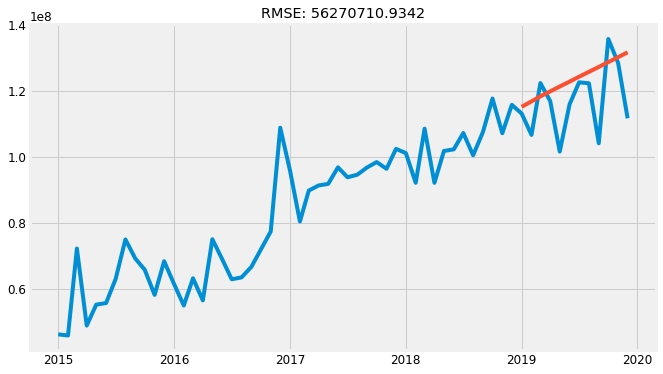

In [98]:
# Taking Exponent to reverse Log Transform:
plt.plot(df4.Total_transactions)
plt.plot(predictions_ARIMA_log)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA_log-ts)**2)/len(ts)))
# red line shows in the plot shows the prediction for test data and prediction seems to be quite okay 

In [99]:
evaluate_forecast(df4[start_index:end_index], predictions_ARIMA_log)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,-0.395853,8.545594e+06,5.436185e+06,1.302638e+14,0.009667,NaN,1.141332e+07


In [116]:
mean_absolute_error(df4[start_index:end_index], predictions_ARIMA_log)


8545594.045902131

### SARIMA 

In [117]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit model
model = SARIMAX(train, order=(3, 1, 3), seasonal_order=(1, 1, 1, 1))
model_fit = model.fit(disp=False)

C:\Users\navod\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\navod\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [118]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)


In [119]:
mse = mean_squared_error(df4[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 14518309.072117511, MSE:210781298313529.62


Text(0.5, 1.0, 'RMSE: 14518309.0721')

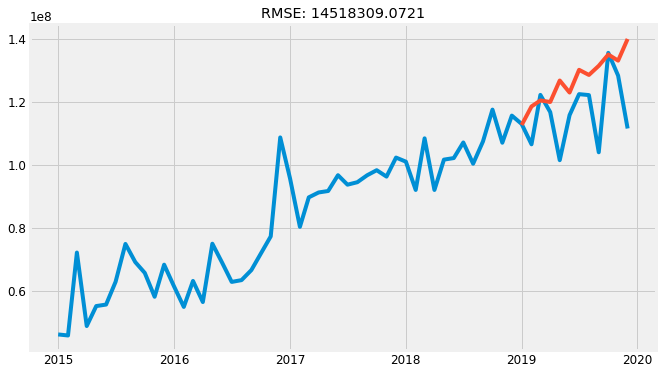

In [120]:
plt.plot(df4)
plt.plot(predictions)
plt.title('RMSE: %.4f'% rmse)

In [121]:
evaluate_forecast(df4[start_index:end_index], predictions)


,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,-1.258645,1.041236e+07,6.778387e+06,2.107813e+14,0.014914,NaN,1.451831e+07


In [122]:
mean_absolute_error(df4[start_index:end_index],predictions)

10412364.568179397

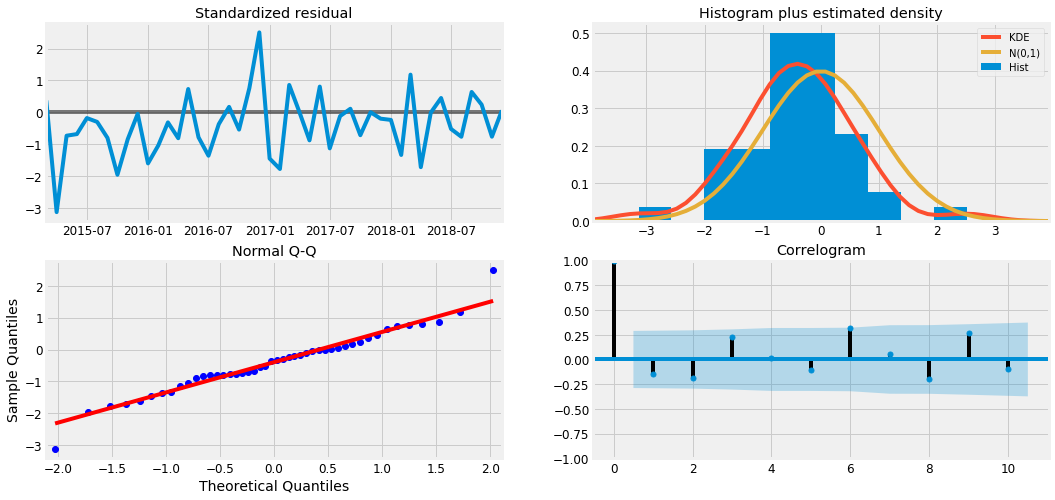

In [106]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

### Model diagnostics:
Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean.

If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

The model diagnostic suggests that the model residual is normally distributed based on the following: In the top right plot, the red KDE line follows closely with the N(0,1) line. Where, N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation of 1. This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution. Again, this is a strong indication that the residuals are normally distributed.

The residuals over time (top left plot) display seasonality

This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

### A good forecasting method will yield residuals with the following properties:

The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.
The residuals have constant variance.
The residuals are normally distributed.

A forecast method that minimises the MAE will lead to forecasts of the median, while minimising the RMSE will lead to forecasts of the mean. Consequently, the RMSE is also widely used, despite being more difficult to interpret.

Transformations such as logarithms can help to stabilise the variance of a time series. Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

